##### Copyright 2019 The TensorFlow Authors.

Пархоменко Александр

In [57]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Модель-трансформер для понимания языка

В этом руководстве <a href="https://arxiv.org/abs/1706.03762" class="external">модель Transformer</a> обучается переводу используя [набор данных Русско-Английского перевода](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translateru_to_en).

Это расширенный пример, который предполагает знание [генерации текста](https://www.tensorflow.org/text/tutorials/text_generation) а также [внимания](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

Этот учебник демонстрирует, как построить модель трансформера и большинство ее компонентов *с нуля* с использованием низкоуровневых функций Tensorflow и Keras. Некоторые из них могут быть сведены к минимуму, если вы воспользуетесь встроенными API, как `tf.keras.layers.MultiHeadAttention`.

Основной идея модели трансформера — это *самовнимание* — способность обращать внимание на различные позиции входной последовательности для вычисления представления этой последовательности. Трансформер создает стек слоев собственного внимания и объясняется ниже в разделах *Масштабированное скалярное произведение внимания* и *Внимание с несколькими головками*.

Модель трансформера обрабатывает входные данные переменного размера, используя стеки уровней внутреннего внимания вместо [РНС](https://www.tensorflow.org/text/tutorials/text_classification_rnn) или [СНС](https://www.tensorflow.org/tutorials/images/cnn). Эта общая архитектура имеет ряд преимуществ:

* Она не делает предположений о временных/пространственных отношениях между данными. Это идеально подходит для обработки набора объектов.
* Выходы слоя могут быть рассчитаны параллельно, а не серией, как в архитектуре РНС.
* Отдаленные элементы могут влиять на выход друг друга, не проходя через множество шагов РНС или слои свертки (см., например: [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf)).
* Она может изучать долгосрочные зависимости. Это проблема во многих задачах с последовательным принятием решений.

Недостатки этой архитектуры:

* Для временного ряда выходные данные для временного шага рассчитываются из *всей истории* вместо только из входных данных и текущего скрытого состояния. Это *может* быть менее эффективным.   
* Если входные данные *имеют* временные/пространственные отношения, например, текст, необходимо добавить некоторое позиционное кодирование, иначе модель фактически увидит набор слов. 

После обучения модели в этом руководстве вы сможете ввести английское предложение и вернуть русский перевод.

<img src="https://github.com/AlexandrParkhomenko/ai/raw/main/cs25/attention_map_portuguese.png" width="800" alt="Attention heatmap">

## Настройка

In [58]:
#!pip install tensorflow_datasets
 #!pip install libclang
 #!pip install tensorflow-io-gcs-filesystem
#!pip install -U tensorflow-text

In [59]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

In [60]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Загрузка набора данных

Используйте [TensorFlow datasets](https://www.tensorflow.org/datasets) чтобы загрузить [набор данных Русско-Английского перевода](https://github.com/neulab/word-embeddings-for-nmt) из проекта [Открытого перевода TED](https://www.ted.com/participate/translate).

In [61]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples, val_test = examples['train'], examples['validation'], examples['test']

In [62]:
len(examples['train'].batch(1).take(208106))
print('Этот набор данных содержит %s примеров обучения, %s примеров валидации и тестовых примеров %s.' \
% (len(train_examples), len(val_examples), len(val_test)))

Этот набор данных содержит 208106 примеров обучения, 4805 примеров валидации и тестовых примеров 5476.


Объект `tf.data.Dataset`, возвращаемый наборами данных TensorFlow, дает пары текстовых примеров:

In [63]:
for ru_examples, en_examples in train_examples.batch(3).take(1):
  for ru in ru_examples.numpy():
    print(ru.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

к : успех , перемены возможны только с оружием в руках .
документация и методика практического обучения также доступна и выпущена creative commons .
( видео ) диди пиклз : сейчас четыре часа утра .

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


2023-10-11 21:19:39.136851: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Текст - токенизация и детокенизация

Вы не можете тренировать модель непосредственно на тексте. Сначала текст необходимо преобразовать в числовое представление. Как правило, вы конвертируете текст в последовательности идентификаторов токенов, которые используются в качестве индексов во встраивании.

Одна популярная реализация демонстрируется в учебнике [Токенизаторы на уровне слов](https://github.com/AlexandrParkhomenko/ai/blob/main/cs25/subwords_tokenizer.ipynb) строит токенизаторы (`text.BertTokenizer`) оптимизированные для этого набора данных и экспортирует их в [saved_model](https://www.tensorflow.org/guide/saved_model).

Загрузите, распакуйте и импортируйте `saved_model`:

In [64]:
model_name = 'ted_hrlr_translate_ru_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://github.com/AlexandrParkhomenko/ai/raw/main/cs25/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_ru_en_converter.zip'

In [65]:
tokenizers = tf.saved_model.load(model_name)

Объект `tokenizers` содержит два текстовых токенизатора, один для английского и один для русского. Оба имеют одинаковые методы:

In [66]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

Метод `tokenize` преобразует партию строк в дополнительную партию токен-идентификаторов. разделяет знаки препинания, строчные буквы и нормализует входные данные перед токенизацией. Эта стандартизация здесь не видна, потому что входные данные уже стандартизированы.

In [67]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .
( video ) didi pickles : it 's four o'clock in the morning .


In [68]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 41, 28, 1103, 14, 84, 243, 93, 200, 389, 218, 84, 6405, 87, 84, 2473, 16, 3]
[2, 84, 3914, 464, 85, 84, 702, 15, 104, 1495, 2346, 2024, 93, 187, 435, 15, 942, 85, 2533, 111, 84, 1068, 5725, 16, 3]
[2, 10, 400, 11, 168, 379, 1026, 1125, 28, 90, 9, 57, 316, 53, 9, 2501, 89, 84, 813, 16, 3]


Метод `detokenize` пытается преобразовать эти идентификаторы токенов обратно в человекочитаемый текст: 

In [69]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

c : success , the change is only coming through the barrel of the gun .
the documentation and the hands - on teaching methodology is also open - source and released as the creative commons .
( video ) didi pickles : it ' s four o ' clock in the morning .


Низкоуровневый метод `lookup` преобразует токен-идентификаторы в текст:

In [70]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'c', b':', b'success', b',', b'the', b'change', b'is',
  b'only', b'coming', b'through', b'the', b'barrel', b'of', b'the', b'gun',
  b'.', b'[END]']                                                          ,
 [b'[START]', b'the', b'document', b'##ation', b'and', b'the', b'hands',
  b'-', b'on', b'teaching', b'method', b'##ology', b'is', b'also', b'open',
  b'-', b'source', b'and', b'released', b'as', b'the', b'creative',
  b'commons', b'.', b'[END]']                                              ,
 [b'[START]', b'(', b'video', b')', b'did', b'##i', b'pick', b'##les', b':',
  b'it', b"'", b's', b'four', b'o', b"'", b'clock', b'in', b'the',
  b'morning', b'.', b'[END]']                                               ]>

Здесь вы можете увидеть аспект «разбора слов» в токенизаторах. Слово "searchability" разлагается на "search ##ability" и слово "serendipity" в "s ##ere ##nd ##ip ##ity"

Теперь уделите минуту, чтобы исследовать распределение токенов примера в наборе данных:

In [71]:
lengths = []

for ru_examples, en_examples in train_examples.batch(1024):
  ru_tokens = tokenizers.ru.tokenize(ru_examples)
  lengths.append(ru_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

............................................................................................................................................................................................................

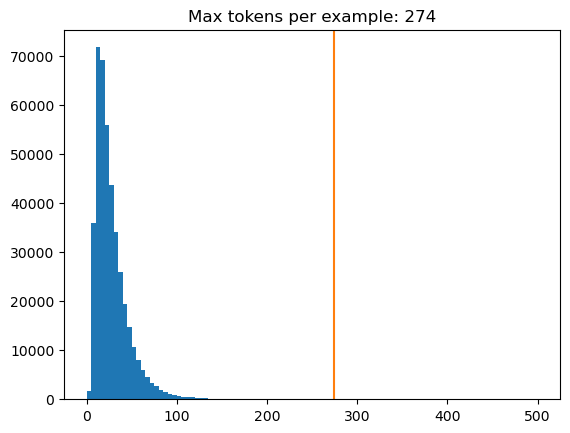

In [72]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');

In [73]:
MAX_TOKENS = 128

## Настройка входного конвейера

Чтобы построить входной конвейер, подходящий для обучения, определите некоторые функции для преобразования набора данных.

Определите функцию, чтобы отбрасывать примеры длиннее, чем `MAX_TOKENS`:

In [74]:
def filter_max_tokens(ru, en):
  num_tokens = tf.maximum(tf.shape(ru)[1],tf.shape(en)[1])
  return num_tokens < MAX_TOKENS

Определите функцию, которая токенизирует партии необработанного текста:

In [75]:
def tokenize_pairs(ru, en):
    ru = tokenizers.ru.tokenize(ru)
    # Convert from ragged to dense, padding with zeros.
    ru = ru.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return ru, en

Вот простой входной конвейер, который обрабатывает, перемешивает и формирует партии данных:

In [76]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [77]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Позиционное кодирование

Слои внимания видят свои входные данные как набор векторов без последовательного порядка. Эта модель также не содержит никаких рекуррентных или сверточных слоев. Из-за этого добавляется «позиционное кодирование», чтобы дать модели некоторую информацию об относительной позиции токенов в предложении. 

Вектор позиционного кодирования добавляется к [вектору отпечатков](https://ru.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s). Отпечатки представляют собой токен в D-размерном пространстве, где токены с одинаковым значением будут ближе друг к другу. Но отпечатки не кодируют относительное положение токенов в предложении. Таким образом, после добавления позиционного кодирования токены будут ближе друг к другу, на основе *схожести их значения и их положения в предложении*, в D-размерном пространстве.

Формула для расчета позиционного кодирования заключается в следующем:

$${PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$${PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [78]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [79]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


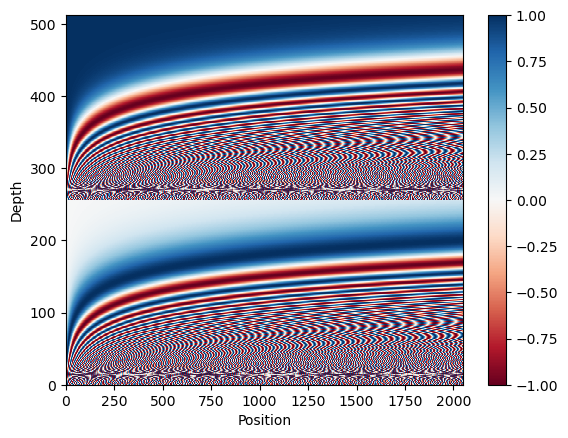

In [80]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Маскировка

Замаскируйте все токены заполнения в пакете последовательности. Это гарантирует, что модель не рассматривает заполнения как вход. Маска указывает, где присутствует значение заполнения `0`: она выводит `1` в этих местах, и `0` в противном случае.

In [81]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # добавить дополнительные размерности, чтобы добавить отступ
  # к логитам внимания.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [82]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

Упреждающая маска используется для маскировки будущих токенов в последовательности. Другими словами, маска указывает, какие записи не следует использовать.

Это означает, что для прогнозирования третьего токена будет использоваться только первый и второй токен. Точно так же, чтобы предсказать четвертый токен, будут использоваться только первый, второй и третий токены и так далее.

In [83]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [84]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

Примечание: Эта маска указывает, какие записи *не* принимают во внимание. Тем не менее, слой MultiHeadAttention в Керасе, который был добавлен после создания этого руководства, рассматривает перевернутую маску, где 1 - токен, который следует принять и 0 следует игнорировать. Если вы используете `tf.keras.layers.MultiHeadAttention` вместо MultiHeadAttention слоя в этом руководстве, определенном ниже, используйте следующий прокомментированный метод для генерации маски. Вам нужно будет `pip install tensorflow-probability` и `import tensorflow_probability as tfp`.

In [85]:
# def create_look_ahead_mask(size):
#     n = int(size * (size+1) / 2)
#     mask = tfp.math.fill_triangular(tf.ones((n,), dtype=tf.int32), upper=False)

## Внимание масштабированного скалярного произведения

<img src="https://github.com/AlexandrParkhomenko/ai/raw/main/cs25/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Функция внимания, используемая трансформером, принимает три входа: Q (query/запрос), K (key/ключ), V (value/значение). Уравнение, используемое для расчета весов внимания, выглядит следующим образом:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

Скалярное произведение внимания масштабируется коэффициентом квадратного корня из глубины. Это делается потому, что для больших значений глубины скалярное произведение становится большим по величине, подталкивая функцию softmax, где она имеет небольшие градиенты, что приводит к очень жесткому softmax.

Например, предположим, что `Q` и `K` имеют среднее значение 0 и дисперсию 1. Их матричное умножение будет иметь среднее значение 0 и дисперсию `dk`. 
Таким образом, *квадратный корень из `dk`* используется для масштабирования, поэтому вы получаете постоянную дисперсию независимо от значения` dk`. Если дисперсия слишком низкая, выход может быть слишком плоскими для эффективной оптимизации. Если дисперсия слишком высока, softmax может насыщать при инициализации, что затрудняет обучение.

Маска умножается на -1e9 (близко к минус бесконечности). Это делается потому, что маска суммируется с масштабированным матричным умножением Q и K и применяется непосредственно перед softmax. Цель состоит в том, чтобы обнулить эти ячейки, а большие отрицательные входные данные для softmax близки к нулю на выходе.

In [86]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Поскольку нормализация softmax выполняется по размерности ключей `K`, значения `V` внимания определяют степень важности, придаваемой ключам для каждого запроса `Q`.

Выход представляет умножение веса внимания и вектор `V` (значение). Это гарантирует, что токены, на которых вы хотите сосредоточиться, хранятся как есть, а нерелевантные токены удаляются.

In [87]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [88]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [89]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [90]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


 Передайте все запросы вместе.

In [91]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Многоголовое внимание

<img src="https://github.com/AlexandrParkhomenko/ai/raw/main/cs25/multi_head_attention.png" width="500" alt="multi-head attention">


Многоголовое внимание состоит из четырех частей:
*    Полносвязные слои.
*    Слои масштабированного скалярного произведения внимания.
*    Соединение каскадов 
*    Последний линейный слой.

Каждый многоголовый блок внимания получает три входа; Q (query/запрос), K (key/ключ), V (value/значение). Они проводятся через линейные (`Dense`) слои перед функцией внимания с несколькими головками.

На приведенной выше диаграмме `(K,Q,V)` проходят через отдельные линейные (`Dense`) слои для каждой головы внимания. Для простоты/эффективности код ниже реализует это с помощью одного плотного слоя с с числом выходов, умноженным на `num_heads`. Выход преобразуется в форму `(batch, num_heads, ...)` перед применением функции внимания.

Функция `scaled_dot_product_attention`, определенная выше, применяется в одном вызове, транслируемой для эффективности. Соответствующая маска должна использоваться на шаге внимания.  Вывод внимания для каждой головы затем объединяется (с помощью `tf.transpose`, и `tf.reshape`) и проходит финальный `Dense` слой.

Вместо одной головки внимания Q, K и V разделены на несколько голов, поскольку она позволяет модели обращать внимание на информацию из разных подпространств представления в разных позициях. После разделения каждая голова имеет уменьшенную размерность, поэтому общая стоимость вычисления одинакова, что и внимание на одной головке с полной размерностью.

In [92]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

`MultiHeadAttention` Создайте слой, чтобы попробовать. В каждом месте в последовательности, `y`, `MultiHeadAttention` запускает все 8 головок внимания во всех других местах в последовательности, возвращая новый вектор одинаковой длины в каждом месте.

In [93]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Полносвязные слои

Сеть точечной прямой связи состоит из двух полностью связанных слоев с активацией ReLU между ними.

In [94]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [95]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Энкодер и декодер

<img src="https://github.com/AlexandrParkhomenko/ai/raw/main/cs25/transformer.png" width="600" alt="transformer">

Модель трансформера следует тому же общему шаблону, что и стандарт [последовательность в последовательности с моделью внимания](https://www.tensorflow.org/text/tutorials/nmt_with_attention.ipynb). 

* Входное предложение передается через `N` слоев кодировщика, который генерирует выходные данные для каждого токена в последовательности.
* Декодер обращается к выходу энкодера и его собственным входу (самовнимание), чтобы предсказать следующее слово. 

### Слой энкодера

Каждый слой энкодера состоит из подслоев:

1.   Многоголовоцное внимание (с маской заполнения)
2.   Полносвязные сети прямого распространения.

Каждый из этих подслоев имеет остаточную связь вокруг него с последующей нормализацией слоя. Остаточные соединения помогают избежать проблемы исчезновения градиента в глубоких сетях.

Вывод каждого подслоя `LayerNorm(x + Sublayer(x))`. Нормализация проводится на (последней) оси `d_model`. В трансформере есть N слоев кодировщика.

In [96]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [97]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Слой декодера

Каждый слой декодера состоит из подслоев:

1.   Маскированное многоголовое внимание (с маской упреждения и маской заполнения)
2.   Многоголовое внимание (с маской заполнения). V (value/значение) и K (key/ключ) получают *выходные данные энкодера* в качестве входов. Q (query/запрос) получает *вывод от маскированного многоголового подслоя внимания*.
3.   Полносвязные сети прямого распространения.

Каждый из этих подслоев имеет остаточную связь вокруг него с последующей нормализацией слоя. Вывод каждого подслоя `LayerNorm(x + Sublayer(x))`. Нормализация проводится на (последней) оси `d_model`. 

В трансформере есть N слоев декодера.

Поскольку Q получает выходной сигнал от первого блока внимания декодера, а K получает выходной сигнал энкодера, веса внимания представляют важность, придаваемое входу декодера на основе вывода энкодера. Другими словами, декодер предсказывает следующий токен, глядя на вывод энкодера и самостоятельно обращаясь к своим собственным выводам. См. Демонстрацию выше в разделе «Внимание масштабированного скалярного произведения».

In [98]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [99]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Энкодер

`Encoder` состоит из:
1.   Входные Отпечатки (Embedding)
2.   Позиционное кодирование
3.   N слоев энкодера

Ввод пропускается через слой отпечатков, который суммируется с позиционным кодированием. Выход этого суммирования является входом в слои энкодера. Выход энкодера является входом в декодер.

In [100]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [101]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Декодер

`Decoder` состоит из:
1.   Выходные Отпечатки (Embedding)
2.   Позиционное кодирование
3.   N слоев декодера

Цель проходит через слой отпечатков, которые суммируется с позиционным кодированием. Выход этого суммирования является входом для слоев декодера. Выход декодера является входом для конечного линейного слоя.

In [102]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [103]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Создание модели трансформера

Трансформер состоит из энкодера, декодера и завершающего линейного слоя. Выход декодера является входом для линейного слоя, и его выход возвращается.

In [104]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [105]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Установка гиперпараметров

ACHTUNG!

Чтобы сохранить этот пример небольшим и относительно быстрым, значения для `num_layers, d_model, dff` были уменьшены. 

Базовая модель, описанная в [paper](https://arxiv.org/abs/1706.03762) использовала: `num_layers=6, d_model=512, dff=2048`.

In [106]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Оптимизатор

Используйте оптимизатор Adam с настраиваемым планировщиком скорости обучения в соответствии с формулой в [работе](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [128]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [129]:
learning_rate = 0.001 #CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

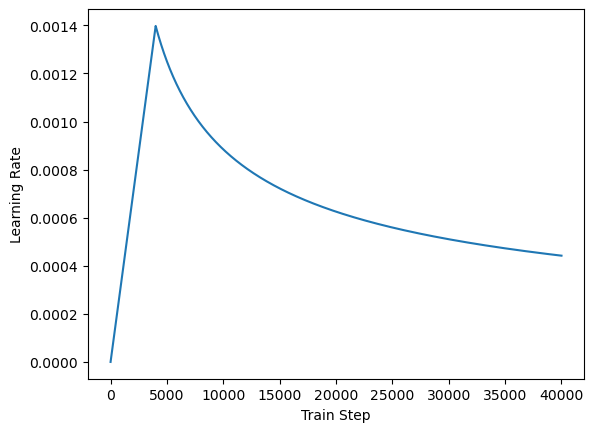

In [130]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Функция потерь и метрики

Поскольку целевые последовательности дополняются, важно применить маску заполнения при расчете потерь.

In [131]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [132]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [133]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Тренировка и контрольные точки

In [134]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.ru.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

Создайте путь к контрольной точке и менеджер контрольных точек. Это будет использоваться для сохранения контрольных точек каждые `n` эпох.

In [135]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

Цель делится на tar_inp и tar_real. tar_inp передается в качестве входных данных в декодер. `tar_real` — это тот же вход смещенный на 1: в каждом месте в `tar_input`, `tar_real` содержит следующий токен, который должен быть предсказан.

Например, `sentence = 'SOS Лев спит в джунглях EOS'` становится:

* `tar_inp =  'SOS Лев спит в джунглях'`
* `tar_real = 'Лев спит в джунглях EOS'`

Трансформер — это авторегрессивная модель: она делает прогнозы по одной части за раз и использует свой выход, чтобы решить, что делать дальше.

Во время обучения в этом примере используется усиление учителем (как, например, в руководстве по [генерации текста](https://www.tensorflow.org/text/tutorials/text_generation)). Усиление учителем передает истинный выход на следующий временной шаг, независимо от того, что модель предсказывает на настоящем временном шаге.

Поскольку модель предсказывает каждый токен, *внутреннее внимание* позволяет ей смотреть на предыдущие токены во входной последовательности, чтобы лучше предсказать следующий токен.

Чтобы модель не заглядывала на ожидаемый вывод, модель использует упреждающую маску.

In [136]:
EPOCHS = 20

In [137]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Русский язык используется в качестве языка ввода, а английский язык является целевым языком.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> Русский, tar -> English
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.9895 Accuracy 0.0000
Epoch 1 Batch 50 Loss 6.9586 Accuracy 0.0438
Epoch 1 Batch 100 Loss 6.6099 Accuracy 0.0516
Epoch 1 Batch 150 Loss 6.4847 Accuracy 0.0537
Epoch 1 Batch 200 Loss 6.4066 Accuracy 0.0580
Epoch 1 Batch 250 Loss 6.3473 Accuracy 0.0636
Epoch 1 Batch 300 Loss 6.2997 Accuracy 0.0676
Epoch 1 Batch 350 Loss 6.2720 Accuracy 0.0696
Epoch 1 Batch 400 Loss 6.2541 Accuracy 0.0708
Epoch 1 Batch 450 Loss 6.2390 Accuracy 0.0715
Epoch 1 Batch 500 Loss 6.2424 Accuracy 0.0689
Epoch 1 Batch 550 Loss 6.2429 Accuracy 0.0670
Epoch 1 Batch 600 Loss 6.2384 Accuracy 0.0659
Epoch 1 Batch 650 Loss 6.2332 Accuracy 0.0652
Epoch 1 Batch 700 Loss 6.2291 Accuracy 0.0649
Epoch 1 Batch 750 Loss 6.2240 Accuracy 0.0650
Epoch 1 Batch 800 Loss 6.2174 Accuracy 0.0653
Epoch 1 Batch 850 Loss 6.2091 Accuracy 0.0660
Epoch 1 Batch 900 Loss 6.1971 Accuracy 0.0675
Epoch 1 Batch 950 Loss 6.1880 Accuracy 0.0689
Epoch 1 Batch 1000 Loss 6.1876 Accuracy 0.0685
Epoch 1 Batch 1050 Loss 6.1870 Accur

Epoch 4 Batch 500 Loss 4.7904 Accuracy 0.2285
Epoch 4 Batch 550 Loss 4.7891 Accuracy 0.2287
Epoch 4 Batch 600 Loss 4.7876 Accuracy 0.2290
Epoch 4 Batch 650 Loss 4.7856 Accuracy 0.2293
Epoch 4 Batch 700 Loss 4.7825 Accuracy 0.2294
Epoch 4 Batch 750 Loss 4.7801 Accuracy 0.2298
Epoch 4 Batch 800 Loss 4.7789 Accuracy 0.2299
Epoch 4 Batch 850 Loss 4.7759 Accuracy 0.2302
Epoch 4 Batch 900 Loss 4.7704 Accuracy 0.2309
Epoch 4 Batch 950 Loss 4.7663 Accuracy 0.2315
Epoch 4 Batch 1000 Loss 4.7635 Accuracy 0.2318
Epoch 4 Batch 1050 Loss 4.7609 Accuracy 0.2322
Epoch 4 Batch 1100 Loss 4.7600 Accuracy 0.2323
Epoch 4 Batch 1150 Loss 4.7573 Accuracy 0.2325
Epoch 4 Batch 1200 Loss 4.7548 Accuracy 0.2328
Epoch 4 Batch 1250 Loss 4.7531 Accuracy 0.2330
Epoch 4 Batch 1300 Loss 4.7512 Accuracy 0.2331
Epoch 4 Batch 1350 Loss 4.7494 Accuracy 0.2334
Epoch 4 Batch 1400 Loss 4.7478 Accuracy 0.2335
Epoch 4 Batch 1450 Loss 4.7463 Accuracy 0.2337
Epoch 4 Batch 1500 Loss 4.7442 Accuracy 0.2339
Epoch 4 Batch 1550 Loss

Epoch 7 Batch 750 Loss 4.3840 Accuracy 0.2655
Epoch 7 Batch 800 Loss 4.3835 Accuracy 0.2656
Epoch 7 Batch 850 Loss 4.3845 Accuracy 0.2654
Epoch 7 Batch 900 Loss 4.3822 Accuracy 0.2656
Epoch 7 Batch 950 Loss 4.3813 Accuracy 0.2657
Epoch 7 Batch 1000 Loss 4.3800 Accuracy 0.2658
Epoch 7 Batch 1050 Loss 4.3794 Accuracy 0.2659
Epoch 7 Batch 1100 Loss 4.3792 Accuracy 0.2658
Epoch 7 Batch 1150 Loss 4.3794 Accuracy 0.2658
Epoch 7 Batch 1200 Loss 4.3787 Accuracy 0.2660
Epoch 7 Batch 1250 Loss 4.3782 Accuracy 0.2660
Epoch 7 Batch 1300 Loss 4.3781 Accuracy 0.2660
Epoch 7 Batch 1350 Loss 4.3782 Accuracy 0.2659
Epoch 7 Batch 1400 Loss 4.3774 Accuracy 0.2660
Epoch 7 Batch 1450 Loss 4.3773 Accuracy 0.2661
Epoch 7 Batch 1500 Loss 4.3768 Accuracy 0.2662
Epoch 7 Batch 1550 Loss 4.3758 Accuracy 0.2663
Epoch 7 Batch 1600 Loss 4.3750 Accuracy 0.2664
Epoch 7 Batch 1650 Loss 4.3749 Accuracy 0.2664
Epoch 7 Batch 1700 Loss 4.3742 Accuracy 0.2665
Epoch 7 Batch 1750 Loss 4.3736 Accuracy 0.2665
Epoch 7 Batch 1800

Epoch 10 Batch 1150 Loss 4.2395 Accuracy 0.2785
Epoch 10 Batch 1200 Loss 4.2389 Accuracy 0.2786
Epoch 10 Batch 1250 Loss 4.2394 Accuracy 0.2786
Epoch 10 Batch 1300 Loss 4.2388 Accuracy 0.2787
Epoch 10 Batch 1350 Loss 4.2388 Accuracy 0.2788
Epoch 10 Batch 1400 Loss 4.2400 Accuracy 0.2786
Epoch 10 Batch 1450 Loss 4.2398 Accuracy 0.2785
Epoch 10 Batch 1500 Loss 4.2402 Accuracy 0.2786
Epoch 10 Batch 1550 Loss 4.2397 Accuracy 0.2786
Epoch 10 Batch 1600 Loss 4.2394 Accuracy 0.2787
Epoch 10 Batch 1650 Loss 4.2396 Accuracy 0.2787
Epoch 10 Batch 1700 Loss 4.2405 Accuracy 0.2786
Epoch 10 Batch 1750 Loss 4.2402 Accuracy 0.2786
Epoch 10 Batch 1800 Loss 4.2402 Accuracy 0.2785
Epoch 10 Batch 1850 Loss 4.2394 Accuracy 0.2786
Epoch 10 Batch 1900 Loss 4.2392 Accuracy 0.2786
Epoch 10 Batch 1950 Loss 4.2380 Accuracy 0.2787
Epoch 10 Batch 2000 Loss 4.2375 Accuracy 0.2787
Epoch 10 Batch 2050 Loss 4.2377 Accuracy 0.2788
Epoch 10 Batch 2100 Loss 4.2377 Accuracy 0.2788
Epoch 10 Batch 2150 Loss 4.2377 Accuracy

Epoch 13 Batch 1350 Loss 4.1647 Accuracy 0.2855
Epoch 13 Batch 1400 Loss 4.1652 Accuracy 0.2855
Epoch 13 Batch 1450 Loss 4.1646 Accuracy 0.2856
Epoch 13 Batch 1500 Loss 4.1646 Accuracy 0.2855
Epoch 13 Batch 1550 Loss 4.1641 Accuracy 0.2856
Epoch 13 Batch 1600 Loss 4.1647 Accuracy 0.2856
Epoch 13 Batch 1650 Loss 4.1644 Accuracy 0.2857
Epoch 13 Batch 1700 Loss 4.1643 Accuracy 0.2857
Epoch 13 Batch 1750 Loss 4.1638 Accuracy 0.2858
Epoch 13 Batch 1800 Loss 4.1643 Accuracy 0.2857
Epoch 13 Batch 1850 Loss 4.1648 Accuracy 0.2857
Epoch 13 Batch 1900 Loss 4.1644 Accuracy 0.2857
Epoch 13 Batch 1950 Loss 4.1638 Accuracy 0.2858
Epoch 13 Batch 2000 Loss 4.1642 Accuracy 0.2858
Epoch 13 Batch 2050 Loss 4.1638 Accuracy 0.2858
Epoch 13 Batch 2100 Loss 4.1635 Accuracy 0.2858
Epoch 13 Batch 2150 Loss 4.1632 Accuracy 0.2858
Epoch 13 Batch 2200 Loss 4.1632 Accuracy 0.2858
Epoch 13 Batch 2250 Loss 4.1626 Accuracy 0.2858
Epoch 13 Batch 2300 Loss 4.1623 Accuracy 0.2858
Epoch 13 Batch 2350 Loss 4.1621 Accuracy

Epoch 16 Batch 1550 Loss 4.1125 Accuracy 0.2909
Epoch 16 Batch 1600 Loss 4.1114 Accuracy 0.2911
Epoch 16 Batch 1650 Loss 4.1122 Accuracy 0.2911
Epoch 16 Batch 1700 Loss 4.1110 Accuracy 0.2911
Epoch 16 Batch 1750 Loss 4.1104 Accuracy 0.2911
Epoch 16 Batch 1800 Loss 4.1101 Accuracy 0.2911
Epoch 16 Batch 1850 Loss 4.1094 Accuracy 0.2912
Epoch 16 Batch 1900 Loss 4.1087 Accuracy 0.2913
Epoch 16 Batch 1950 Loss 4.1083 Accuracy 0.2914
Epoch 16 Batch 2000 Loss 4.1073 Accuracy 0.2915
Epoch 16 Batch 2050 Loss 4.1067 Accuracy 0.2916
Epoch 16 Batch 2100 Loss 4.1068 Accuracy 0.2916
Epoch 16 Batch 2150 Loss 4.1068 Accuracy 0.2916
Epoch 16 Batch 2200 Loss 4.1063 Accuracy 0.2916
Epoch 16 Batch 2250 Loss 4.1068 Accuracy 0.2915
Epoch 16 Batch 2300 Loss 4.1070 Accuracy 0.2915
Epoch 16 Batch 2350 Loss 4.1071 Accuracy 0.2915
Epoch 16 Batch 2400 Loss 4.1068 Accuracy 0.2915
Epoch 16 Batch 2450 Loss 4.1066 Accuracy 0.2916
Epoch 16 Batch 2500 Loss 4.1070 Accuracy 0.2915
Epoch 16 Batch 2550 Loss 4.1073 Accuracy

Epoch 19 Batch 1800 Loss 4.0615 Accuracy 0.2960
Epoch 19 Batch 1850 Loss 4.0616 Accuracy 0.2960
Epoch 19 Batch 1900 Loss 4.0615 Accuracy 0.2960
Epoch 19 Batch 1950 Loss 4.0612 Accuracy 0.2961
Epoch 19 Batch 2000 Loss 4.0607 Accuracy 0.2961
Epoch 19 Batch 2050 Loss 4.0599 Accuracy 0.2961
Epoch 19 Batch 2100 Loss 4.0598 Accuracy 0.2961
Epoch 19 Batch 2150 Loss 4.0593 Accuracy 0.2962
Epoch 19 Batch 2200 Loss 4.0596 Accuracy 0.2961
Epoch 19 Batch 2250 Loss 4.0589 Accuracy 0.2962
Epoch 19 Batch 2300 Loss 4.0591 Accuracy 0.2961
Epoch 19 Batch 2350 Loss 4.0592 Accuracy 0.2961
Epoch 19 Batch 2400 Loss 4.0590 Accuracy 0.2961
Epoch 19 Batch 2450 Loss 4.0592 Accuracy 0.2961
Epoch 19 Batch 2500 Loss 4.0593 Accuracy 0.2961
Epoch 19 Batch 2550 Loss 4.0585 Accuracy 0.2962
Epoch 19 Batch 2600 Loss 4.0588 Accuracy 0.2962
Epoch 19 Batch 2650 Loss 4.0596 Accuracy 0.2961
Epoch 19 Loss 4.0595 Accuracy 0.2961
Time taken for 1 epoch: 284.57 secs

Epoch 20 Batch 0 Loss 4.2552 Accuracy 0.2712
Epoch 20 Batch 50

### Запуск вывода

Для вывода используются следующие шаги:

* Кодируйте входное предложение, используя русский токенизатор (`tokenizers.ru`). Это вход энкодера.
* Вход декодера инициализируется токеном `[START]`.
* Рассчитайте маски заполнения и упреждающие маски.
* `Декодер` затем выводит прогнозы, глядя на `encoder output` и свой собственный вывод (самовнимание).
* Объедините прогнозируемый токен с входом декодера и передайте его декодеру.
* При таком подходе декодер предсказывает следующий токен на основе предыдущих токенов, которые он предсказывал.

Примечание: Модель оптимизирована для эффективного обучения и делает предсказание следующего токена для каждого токена в выходных данных одновременно. Это избыточно во время вывода, и используется только последний прогноз.  Эту модель можно сделать более эффективной для вывода, если вы рассчитываете только последнее предсказание при запуске в режиме вывода (`training=False`).

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.ru.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is english, initialize the output with the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

Примечание: Эта функция использует развернутый цикл, а не динамический цикл. Он генерирует при каждом вызове. Смотрите пример [Нейронный машинный перевод с вниманием](https://www.tensorflow.org/text/tutorials/nmt_with_attention) реализации с динамическим циклом, который может быть гораздо более эффективным.

Создайте экземпляр этого `Translator` класса и попробуйте несколько раз:

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = 'это проблема, которую мы должны решить.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'и мои соседи слышали об этой идее.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'так что я собираюсь очень быстро поделиться с вами некоторыми историями о некоторых волшебных вещах, которые произошли.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

## Участки внимания

Класс `Translator` возвращает словарь карт внимания, которые вы можете использовать для визуализации внутренней работы модели:

In [ ]:
sentence = 'это первая книга, которую я сделал.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = 'Доброе утро. Что мы планируем на сегодня?'
ground_truth = "Good morning. What are we planning for today?"

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.ru.lookup(in_tokens)[0]
in_tokens

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.ru.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.ru.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Модель хорошо справляется с незнакомыми словами. Слова «трицератопс», «энциклопедия» не были введены в наборе данных, и модель учится переводить их, даже без общего словаря:

In [ ]:
sentence = 'Я читал о трицератопсе в энциклопедии.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Экспорт

Эта модель вывода работает, поэтому теперь экспортируйте её как `tf.saved_model`.

Для этого оберните её еще одним подклассом `tf.Module`, на этот раз с `tf.function` в методе `__call__`:

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

В приведенной выше `tf.function` тлько выходное предложение возвращается. Благодаря [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) в `tf.function` любые ненужные значения никогда не вычисляются.

In [ ]:
translator = ExportTranslator(translator)

Поскольку модель декодирует прогнозы с использованием `tf.argmax`, предсказания детерминированные. Оригинальная модель и загруженная из `SavedModel` модель должны дать идентичные прогнозы:

In [ ]:
translator('это первая книга, которую я сделал.').numpy()

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [ ]:
!ls -l translator/*
#!zip -r translator_ru_en.zip translator


In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('это первая книга, которую я сделал.').numpy()

## Резюме

В этом уроке вы узнали:

* позиционное кодирование
* многоголовое внимание
* важность маскировки 
* и как собрать все это вместе, чтобы построить трансформатор.

Эта реализация попыталась придерживаться реализации 
[original paper](https://arxiv.org/abs/1706.03762). Если вы хотите попрактиковаться, есть много вещей, которые вы можете попробовать. Например: 

* Используйте другой набор данных для обучения трансформера.
* Создать конфигурацию «базовый трансформер» или «трансформер XL» из исходной статьи, изменив гиперпараметры.
* Используйте слои, определенные здесь, для создания реализации [BERT](https://arxiv.org/abs/1810.04805).
* Реализуйте лучевой поиск, чтобы получить лучшие прогнозы.